# Text Analysis of WARC Files

### By making use of this notebook, you will be able to extract text from a WARC file and use different text analysis and distant reading tools to better understand its contents.

This first part installs the warcio library in our Jupyter notebook and checks the different URI's found inside a WARC file just to see that it is running properly.

In [ ]:
pip install warcio

Whenever you see a path to a document, remember to change it to where you have your files or where you want your files saved!

In [ ]:
from warcio.archiveiterator import ArchiveIterator

with open('path/to/BE-942855-2457-92_P.warc.gz.gz', 'rb') as stream:
    for record in ArchiveIterator(stream):
        if record.rec_type == 'response':
            print(record.rec_headers.get_header('WARC-Target-URI'))

Next, we begin the text extraction. In order for the text to come out somewhat clean, we get rid of HTML tags and other markings that muddle the paragraphs.

In [2]:
import re
import html

def extract_text(record):
    if record.rec_type == 'response':
        if record.http_headers:
            content_type = record.http_headers.get_header('Content-Type', '').lower()
            if 'text/html' in content_type:
                html_content = record.content_stream().read().decode('utf-8', 'replace')
                text = re.sub(r'<script[\s\S]+?<\/script>', '', html_content)
                text = re.sub(r'<style[\s\S]+?<\/style>', '', text)
                text = re.sub(r'<[^>]+?>', '', text)
                text = html.unescape(text)
                text = re.sub(r'\s+', ' ', text)
                return text.strip()
    return None

def extract_text_from_warc(warc_filename):
    with open(warc_filename, 'rb') as stream:
        for record in ArchiveIterator(stream):
            text = extract_text(record)
            if text:
                yield text

Let's test it and see what comes out!

In [ ]:
warc_filename = 'path/to/BE-942855-2457-99_P.warc.gz.gz'
for text in extract_text_from_warc(warc_filename):
    print(text)

Whereas the previous extract_text_from_war(warc_filename) function extracts text from a single file, this next function extracts it from a folder of WARC files and turns each into a cleaner text file. This function also makes sure that, if any of the files are corrupt, the script will skip in and simply notify the user that said file cannot be processed. The text file can later be easier analysed and manipulated.

In [4]:
import os
def extract_text_from_each_file(input_folder, output_folder):
    output_counter = 1
    for filename in os.listdir(input_folder):
        if filename.endswith('.warc') or filename.endswith('.gz'):
            output_file = os.path.join(output_folder, f"output_{output_counter}.txt")
            output_counter += 1
            file_path = os.path.join(input_folder, filename)
            try:
                with open(file_path, 'rb') as stream, open(output_file, 'w', encoding='utf-8') as outfile:
                    for record in ArchiveIterator(stream):
                        text = extract_text(record)
                        if text:
                            outfile.write(text + '\n')
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

In [5]:
folder_path = 'path/to/Websites'
output_folder = 'path/to/Websites/EXTRACTED'
extract_text_from_each_file(folder_path, output_folder)

Next, we normalize and lemmatize the text. Given that these websites are in Dutch and French, I download the corresponding Dutch and French corpora from the NLTK library. Furthermore, to ensure that the future script will effectively recognize each language used, I install the langdetect library. For further information on language processing tools, visit https://www.nltk.org/index.html.

In [ ]:
!pip install spacy

In [ ]:
!python -m pip install -U pydantic spacy==3.4.4

In [ ]:
!python -m spacy download nl_core_news_sm
!python -m spacy download fr_core_news_sm
!python -m spacy download en_core_web_sm

In [ ]:
!pip install langdetect

In [26]:
import string
import spacy
import langdetect
# Add here your languages. To see what languages are available in spaCy, check https://spacy.io/models
# I added Dutch, French, and English, as these are the three languages my websites are in.
nlp_en = spacy.load("en_core_web_sm")
nlp_nl = spacy.load("nl_core_news_sm")
nlp_fr = spacy.load("fr_core_news_sm")

def lemmatize_text(text):
    nlp_en.max_length = len(text) + 100
    nlp_nl.max_length = len(text) + 100
    nlp_fr.max_length = len(text) + 100
    try:
        language = detect(text)
    except:
        language = 'unknown'
    
    if language == 'nl':
        doc = nlp_nl(text)
    elif language == 'fr':
        doc = nlp_fr(text)
    else:
        doc = nlp_en(text)
    
    lemmatized_tokens = [token.lemma_ for token in doc if token.is_alpha]
    return ' '.join(lemmatized_tokens)


def normalize_folder(input_folder, output_folder):
    output_counter = 1
    for filename in os.listdir(input_folder):
        if filename.endswith(".txt"):
            input_file = os.path.join(input_folder, filename)
            output_file = os.path.join(output_folder, f"normalized_lemmatized_text_{output_counter}" + ".txt")
            output_counter += 1
            normalized_text = normalize(input_file)
            with open(output_file, 'w', encoding='utf-8') as file:
                file.write(normalized_text)

def normalize(input_file):
    with open(input_file, 'r', encoding='utf-8') as file:
        text = file.read()
        
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text_with_spaces = text.translate(translator)
    text_lowercase = text_with_spaces.lower()

    words = text_lowercase.split()

    filtered_words = [word for word in words if len(word) > 2]

    normalized_text = ' '.join(filtered_words)

    normalized_lemmatized_text = lemmatize_text(normalized_text)

    return normalized_lemmatized_text

This part may take a second! Especially if you have a large number of websites! For reference, processing 8 warcs took about 13 minutes (although I admitedly do not have the fastest computer).

In [27]:
input_folder = 'path/to/Websites/EXTRACTED'
output_folder = 'path/to/EXTRACTED/NORMALIZED'
normalize_folder(input_folder, output_folder)

In order to avoid using words that may not have much bearing on the contents of the page (such as "and" or "the"), it is important to set stopwords that the program will completely erase from the contents of the text.

In [ ]:
import nltk
nltk.download('stopwords')

In [59]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def reprocess_text(input_file):
    with open(input_file, 'r',encoding='utf-8') as file:
        text = file.read()
        
    # I input here some words I noticed the stopwords did not catch and that are not too relevant for
    # this text analysis, or words that are clearly from the code that have no relation to the actual content of
    # the sites. Item 2 in particular had still much code still embedded in the text, which made this list quite
    # more sizable than originally intended, which may cause problems if any of the words--such as 'window'--were
    # actually used within the context of Buddhism in other websites. You can change these to fit your needs.
    custom_stopwords = ['wij','alle','onze','waar','zoals','vzw','contact','google','site','error','find','onclick','website',
                       'search','facebooktwitteremail','open','return','directory','status','server','see','detail','page',
                       'cookie','href','toolbar','scrollbar','menubar','titlebar','copyright','url','request','width','height',
                       'yes','window','resizable','location','false','nofollow','javascript','mail','homeméditationle',
                       'proposagendacontactethiquehomeméditationle','proposagendacontactethique','prpl']    
    
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('dutch') + stopwords.words('french') 
                     + stopwords.words('english'))                             # Make sure you use the stopwords from your 
                                                                               # websites' language!
    stop_words.update(set(string.punctuation))
    stop_words.update(set(custom_stopwords))
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]

    from collections import defaultdict
    frequency = defaultdict(int)
    for token in tokens:
        frequency[token] += 1
        
    processed_corpus = [token for token in tokens if frequency[token] > 1]
    return processed_corpus

def process_folder(input_folder):
    corpus = []
    for filename in os.listdir(input_folder):
        if filename.endswith(".txt"):
            input_file = os.path.join(input_folder, filename)
            processed_text = reprocess_text(input_file)
            corpus.append(processed_text)
    return corpus

In [60]:
processed_corpus = process_folder('path/to/Websites/EXTRACTED/NORMALIZED')

Once the text from the websites is as processed as possible, we can move on to text analysis. Much of this analysis is inspired in the Voyant Tools (https://voyant-tools.org/), so I also strongly recommend to input your text files in there as you will obtain even more insight into your text.

Let's see first the top 10 words across all the websites and how often they appear.

In [36]:
def top_10(corpus):
    top_10_words_per_item = []

    for item in corpus:
        freq_dict = defaultdict(int)
        for word in item:
            freq_dict[word] += 1

        sorted_dictionary = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)

        top_10_words = sorted_dictionary[:10]
        top_10_words_per_item.append(top_10_words)

    return top_10_words_per_item

In [61]:
top_10_tables = top_10(processed_corpus)

for idx, table in enumerate(top_10_tables):
    print(f"Table for item {idx + 1}:")
    print(table)
    print("\n")

Table for item 1:
[('use', 274), ('zen', 230), ('harmonie', 196), ('learn', 98), ('service', 87), ('move', 83), ('sign', 72), ('centre', 71), ('know', 69), ('information', 67)]


Table for item 2:
[('zen', 2838), ('meet', 2753), ('boeddhistische', 1741), ('rel', 1509), ('boeddhisme', 1452), ('belgië', 1234), ('centre', 1143), ('afdrukken', 985), ('pratique', 928), ('gevonden', 924)]


Table for item 3:
[('centrum', 73), ('boeddhisme', 57), ('boeddha', 46), ('boeddhistische', 44), ('shin', 41), ('jiko', 37), ('bijeenkomsten', 35), ('publicatie', 32), ('tempel', 28), ('belgië', 26)]


Table for item 4:
[('meditatie', 96), ('back', 36), ('meditatiedag', 31), ('meditatielessen', 30), ('bron', 27), ('voordelen', 27), ('scholen', 27), ('verenigingen', 26), ('meet', 26), ('bezoek', 24)]


Table for item 5:
[('video', 207), ('soka', 206), ('gakkai', 204), ('international', 164), ('sgi', 163), ('belgium', 110), ('nichiren', 107), ('lotus', 91), ('vimeo', 82), ('boeddhistische', 78)]


Table for

Very interesting! Although not too visual; let's create some bar plots to better see how often the top 10 most used words appeared in these 8 websites.

In [65]:
def create_top_10_df(item):
    freq_dict = defaultdict(int)
    for word in item:
        freq_dict[word] += 1

    sorted_dictionary = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)

    top_10_words = sorted_dictionary[:10]

    df = pd.DataFrame(top_10_words, columns=['Word', 'Frequency'])

    return df

In [77]:
import matplotlib.pyplot as plt

def create_bar_graphs(top_10_tables):
    num_items = len(top_10_tables)
    num_cols = 2 
    num_rows = -(-num_items // num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))
    axs = axs.flatten() 

    for idx, (table, ax) in enumerate(zip(top_10_tables, axs)):
        words = table['Word']
        frequencies = table['Frequency']
        bar_width = 0.4
        x = np.arange(len(words))

        ax.bar(x, frequencies, width=bar_width, label='Frequency', color='skyblue')

        ax.set_xlabel('Words')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Top 10 Words - Website {idx + 1}')
        ax.set_xticks(x)
        ax.set_xticklabels(words, rotation=45, ha='right')
        ax.legend()

    for i in range(num_items, num_cols * num_rows):
        axs[i].remove()

    plt.tight_layout()
    plt.show()

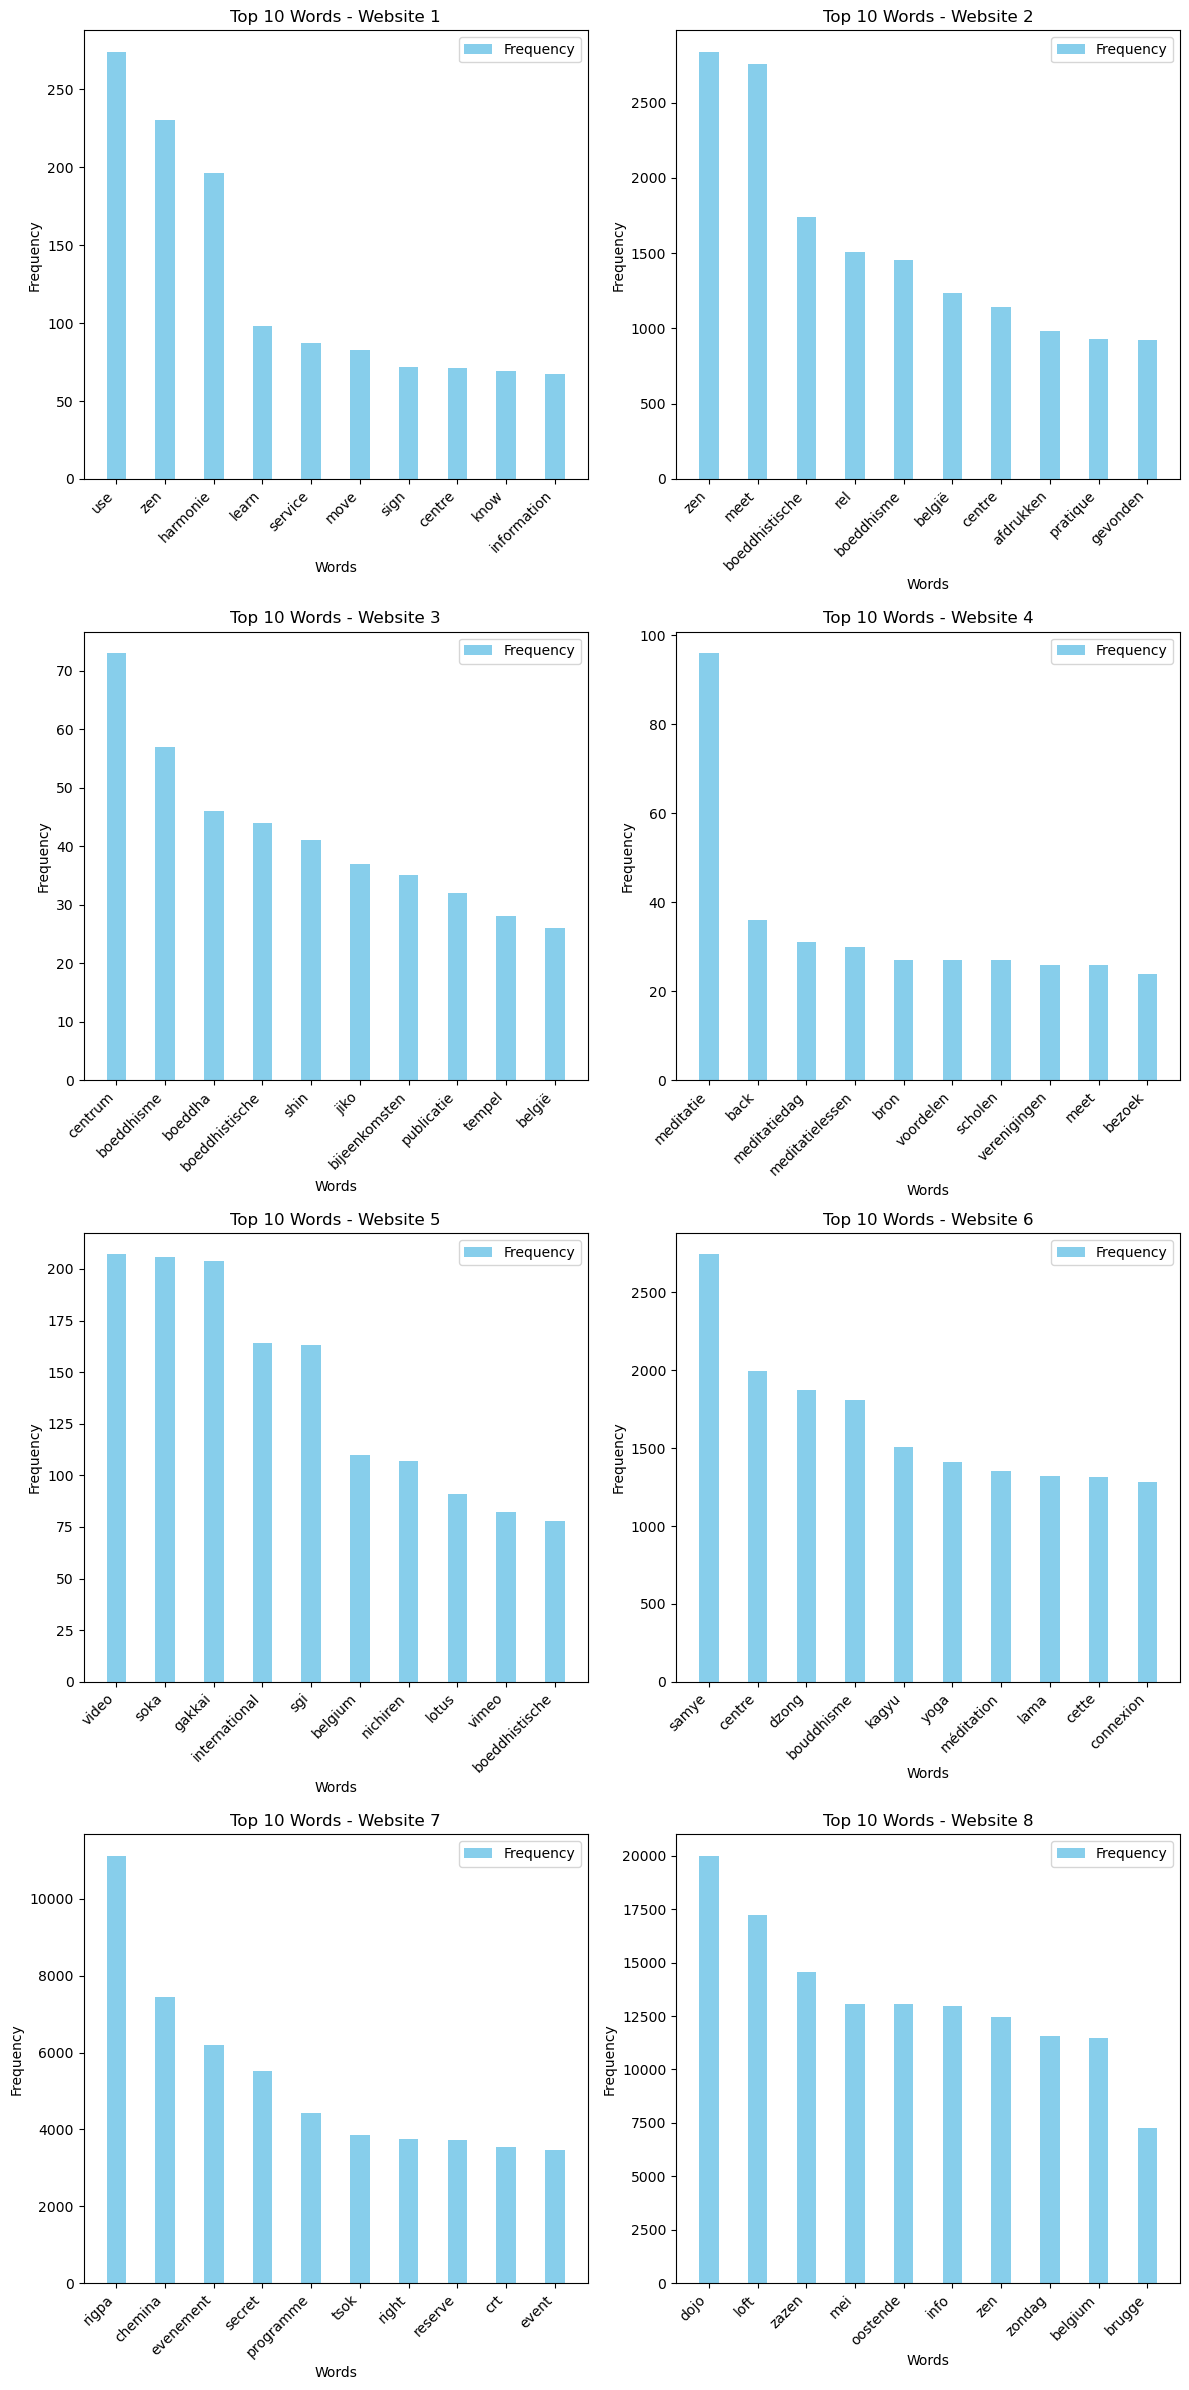

In [78]:
top_10_tables = [create_top_10_df(item) for item in processed_corpus]
create_bar_graphs(top_10_tables)

Let's now see where within each website each of these words appear; of course, we will not be dividing up the words along segments, but rather considering all content of each website as a whole. This way, we may see the sections into which each website is structured, as well as their general goal.

In [81]:
def top_10_no_freq(corpus):
    top_10_words_per_item = []

    for item in corpus:
        freq_dict = defaultdict(int)
        for word in item:
            freq_dict[word] += 1

        sorted_dictionary = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)

        top_10_words = [word for word, _ in sorted_dictionary[:10]]
        top_10_words_per_item.append(top_10_words)

    return top_10_words_per_item

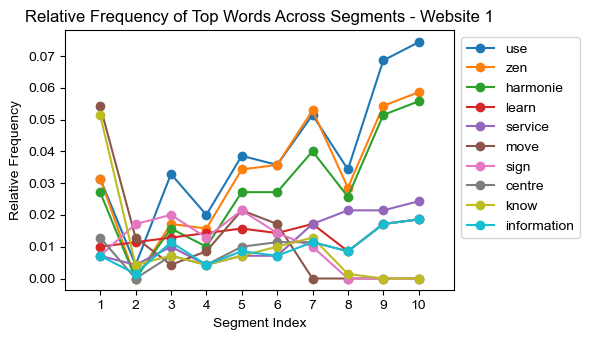

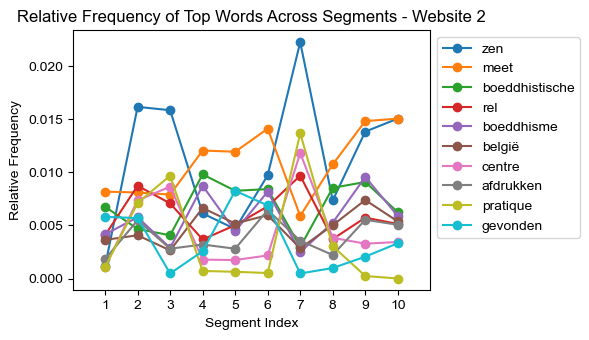

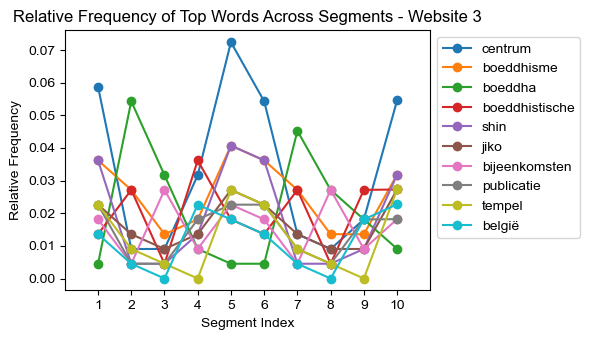

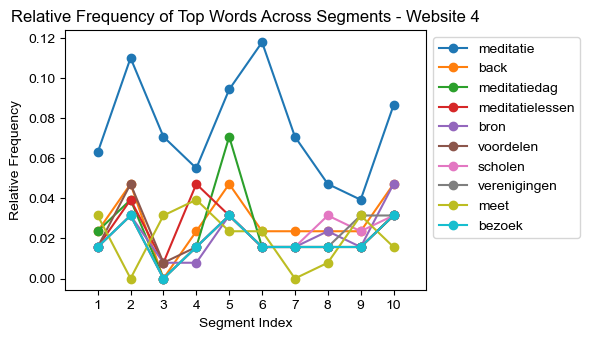

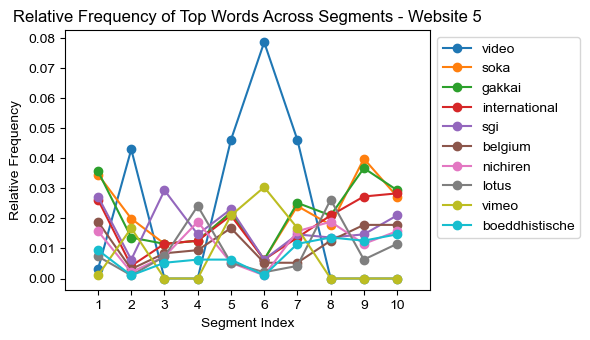

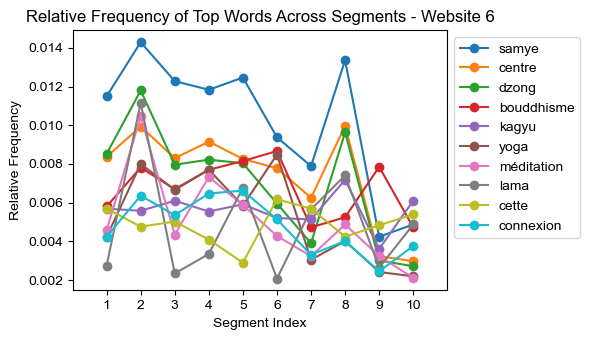

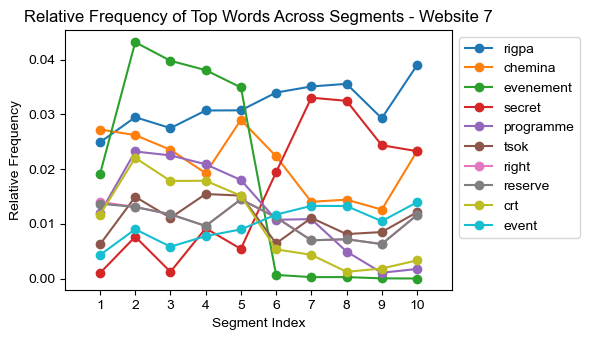

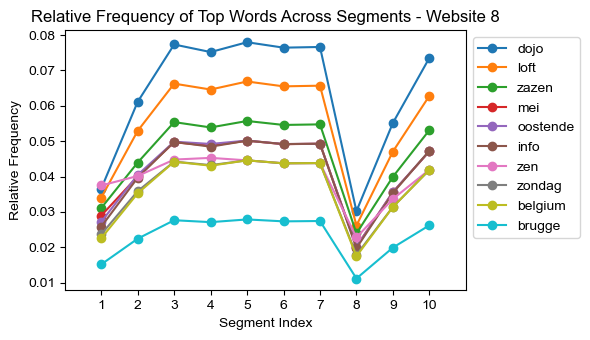

In [166]:
from nltk.probability import FreqDist
import numpy as np

most_common_words = top_10_no_freq(processed_corpus)
num_segments = 10

def divide_text_into_segments(text, num_segments):
    segment_size = len(text) // num_segments
    remainder = len(text) % num_segments

    segments = [text[i * segment_size + min(i, remainder):(i + 1) * segment_size + min(i + 1, remainder)] for i in range(num_segments)]
    return segments

def calculate_relative_frequencies(segment, word):
    freq_dist = FreqDist(segment)
    total_words = len(segment)

    return freq_dist[word] / total_words if total_words > 0 else 0

def plot_relative_frequencies_over_segments(processed_corpus, top_10_words_per_item, num_segments):
    for idx, (text, top_words) in enumerate(zip(processed_corpus, top_10_words_per_item)):
        plt.figure(figsize=(6, 3.5))
        segments = divide_text_into_segments(text, num_segments)

        for word in top_words:
            relative_frequencies = [
                calculate_relative_frequencies(segment, word)
                for segment in segments
            ]

            segment_indices = np.arange(1, num_segments + 1)
            plt.plot(segment_indices, relative_frequencies, marker='o', label=word)

        plt.xlabel("Segment Index")
        plt.ylabel("Relative Frequency")
        plt.title(f"Relative Frequency of Top Words Across Segments - Website {idx + 1}")
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.xticks(segment_indices)
        plt.xlim(0, num_segments + 1)
        plt.tight_layout()
        plt.show()

plot_relative_frequencies_over_segments(processed_corpus, most_common_words, num_segments)


If 10 words become too cramped, we can also do the exact same thing but for 5 words and see what we find!

In [167]:
def top_5_no_freq(corpus):
    top_5_words_per_item = []

    for item in corpus:
        freq_dict = defaultdict(int)
        for word in item:
            freq_dict[word] += 1

        sorted_dictionary = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)

        top_5_words = [word for word, _ in sorted_dictionary[:5]]
        top_5_words_per_item.append(top_5_words)

    return top_5_words_per_item

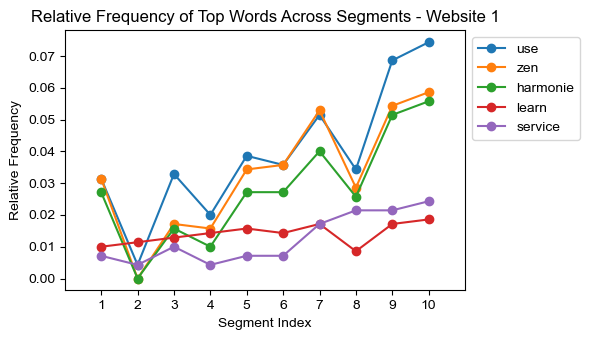

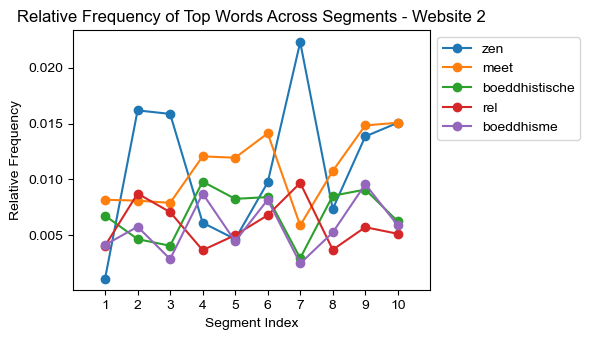

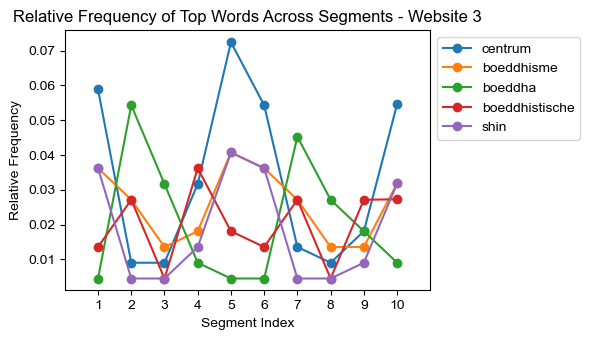

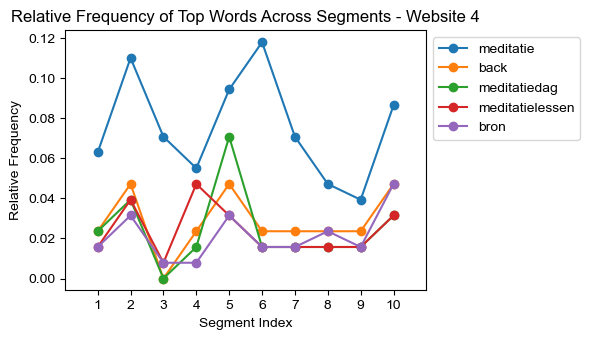

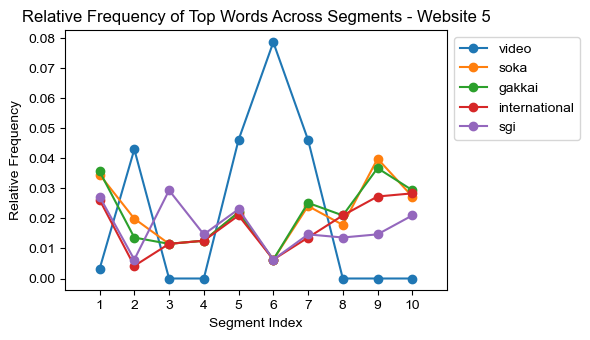

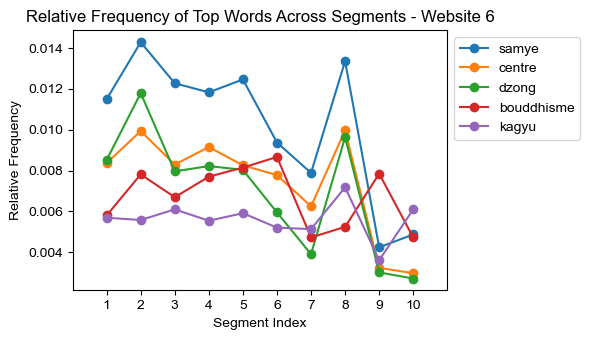

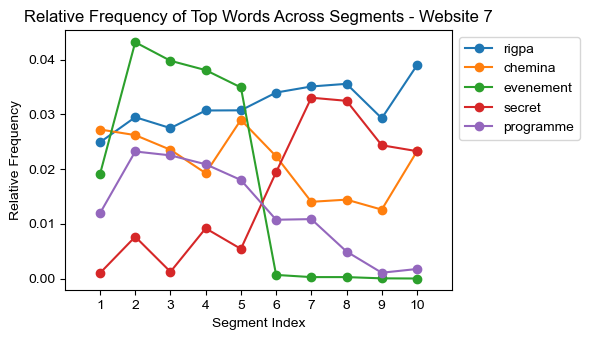

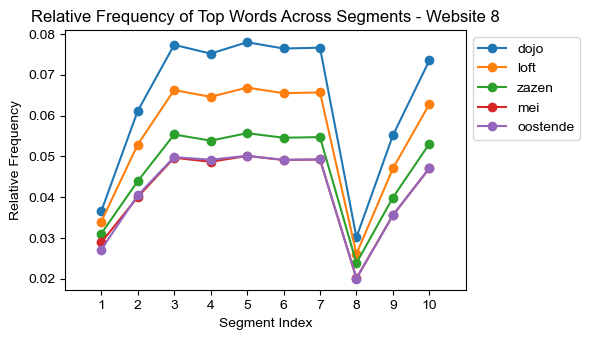

In [168]:
most_common_words = top_5_no_freq(processed_corpus)
num_segments = 10

def divide_text_into_segments(text, num_segments):
    segment_size = len(text) // num_segments
    remainder = len(text) % num_segments

    segments = [text[i * segment_size + min(i, remainder):(i + 1) * segment_size + min(i + 1, remainder)] for i in range(num_segments)]
    return segments

def calculate_relative_frequencies(segment, word):
    freq_dist = FreqDist(segment)
    total_words = len(segment)

    return freq_dist[word] / total_words if total_words > 0 else 0

def plot_relative_frequencies_over_segments(processed_corpus, top_10_words_per_item, num_segments):
    for idx, (text, top_words) in enumerate(zip(processed_corpus, top_10_words_per_item)):
        plt.figure(figsize=(6, 3.5))
        segments = divide_text_into_segments(text, num_segments)

        for word in top_words:
            relative_frequencies = [
                calculate_relative_frequencies(segment, word)
                for segment in segments
            ]

            segment_indices = np.arange(1, num_segments + 1)
            plt.plot(segment_indices, relative_frequencies, marker='o', label=word)

        plt.xlabel("Segment Index")
        plt.ylabel("Relative Frequency")
        plt.title(f"Relative Frequency of Top Words Across Segments - Website {idx + 1}")
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.xticks(segment_indices)
        plt.xlim(0, num_segments + 1)
        plt.tight_layout()
        plt.show()

plot_relative_frequencies_over_segments(processed_corpus, most_common_words, num_segments)

But if you are also interested in the frequency of each specific word, we can create a text reader that allows you to see each word used in a particular website ordered alphabetically and its frequency when you hover over it (remember that list indexes in Python start at 0, so if you want to explore the first website, you should set the item_index as 0, 1 for the second, and so on; since I was most interested in the third website, I set it to 2). It will open a separate window for you to explore the text, which you can simply close once you've finished.

In [ ]:
pip install tk

In [170]:
import tkinter as tk

def calculate_word_frequencies(text):
    words = re.findall(r'\b\w+\b', text.lower())
    freq_dist = FreqDist(words)
    
    unique_words = list(set(words))
    
    sorted_unique_words = sorted(unique_words)
    
    return sorted_unique_words

def on_hover(event):
    index = text.index(tk.CURRENT)
    word = text.get(index + "wordstart", index + "wordend")
    if word:
        freq_info = f"{word}: {word_freq.get(word, 0)}"
        label.config(text=freq_info)

item_index = 2  # Adjust as needed to the number assigned to the website.
                # Remember that Python starts counting at 0, so your Website 1
                # will have index 0, Website 2 will have index 1, and so on.
text_content = '\n'.join(processed_corpus[item_index])

word_freq = {word: text_content.count(word) for word in set(text_content.split())}
sorted_unique_words = calculate_word_frequencies(text_content)

root = tk.Tk()
root.title(f"Website {item_index + 1} -- Word Frequency")
text = tk.Text(root, wrap="word", width=40, height=20)
text.pack(expand=True, fill="both")
text.insert("1.0", '\n'.join(sorted_unique_words))

label = tk.Label(root, text="", anchor="w")
label.pack(fill="x")

text.bind("<Motion>", on_hover)
root.mainloop()

Here you have an example of what the window will look like; as you can see at the bottom, when I hover over the word "boeddhisme" it shows that it appears 57 times throughout the text.

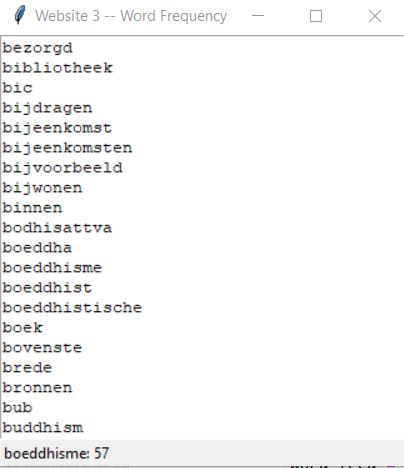

Lastly, we will create a word cloud for one of the websites. Again, you can choose which website by altering the index, and you can also change the maximum amount of words you wish to display. Although word clouds are not particularly useful for research, they sure are visually appealing!

In [ ]:
pip install wordcloud

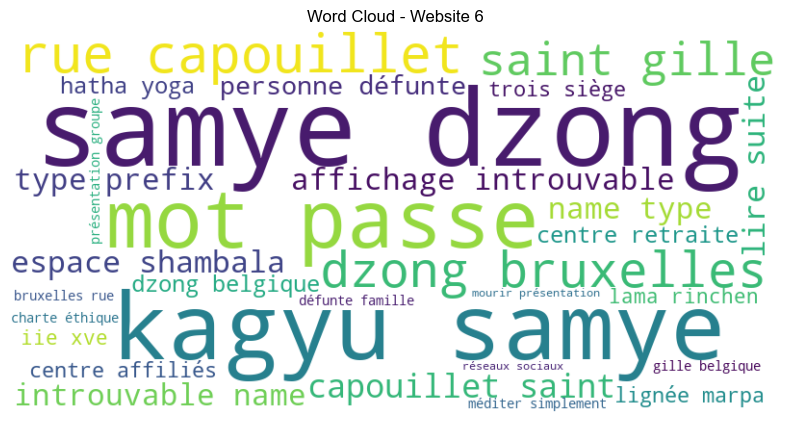

In [177]:
from wordcloud import WordCloud

item_index = 5  # Adjust as needed to the number assigned to the website.
                # Remember that Python starts counting at 0, so your Website 1
                # will have index 0, Website 2 will have index 1, and so on.
text_content = ' '.join(processed_corpus[item_index]) 
max_words = 30  # Adjust as needed to the max number of words you want on the cloud.

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words).generate(text_content)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Word Cloud - Website {item_index + 1}")
plt.show()
